In [1]:
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

cuda = torch.cuda.is_available()

print("Cuda: " + str(cuda))

Cuda: True


In [8]:
# defining generator and discriminator architecture, taken from Github Pytorch-GAN (need to modify hyperparams)
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=(2,)):
        super(Generator, self).__init__()
        
        self.img_shape = img_shape
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 400, normalize=False),
            *block(400, 400),
            *block(400, 400),
            *block(400, 400),
            nn.Linear(400, int(np.prod(img_shape))),
            nn.Tanh()
        )
        
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img
    
class Discriminator(nn.Module):
    def __init__(self, img_shape=(2,)):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 200),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(200, 200),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [9]:
# define synthetic distribution
# Mixture of 25 two-dimensional spherical Gaussians 
#   with means $(-4 + 2i, -4+2j)$ and variances 
#   $0.0025$ for $i, j \in \setmath{0, 1, 2, 3, 4}$

def sample_from_2dgrid(grid_length=5, var=0.0025, num_samples=1):
    assert grid_length % 2 == 1
    samples = []
    # pick one of the Gaussians at random and then sample from it
    for i in range(num_samples):
        coords = np.random.randint(grid_length, size = 2)
        start = -2 * (grid_length // 2)
        mean = (coords[0] * 2 + start, coords[1] * 2 + start)
        p1 = np.random.normal(loc = mean[0], scale = np.sqrt(var))
        p2 = np.random.normal(loc = mean[1], scale = np.sqrt(var))
        samples.append((p1, p2))
    return samples

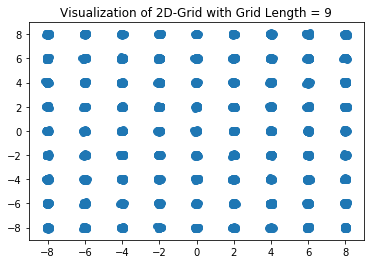

In [4]:
# here's what the 2D-Grid looks like
num_samples = 10000
grid_length=9
samples = sample_from_2dgrid(grid_length=grid_length, num_samples=num_samples)
x = [samples[i][0] for i in range(num_samples)]
y = [samples[i][1] for i in range(num_samples)]
plt.title("Visualization of 2D-Grid with Grid Length = %d" % grid_length)
plt.scatter(x, y)

[Epoch 0/10000] [Discriminator Loss: 0.672287] [Generator Loss: 0.649341]


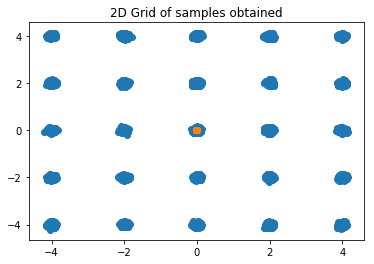

[Epoch 500/10000] [Discriminator Loss: 0.513120] [Generator Loss: 0.449773]


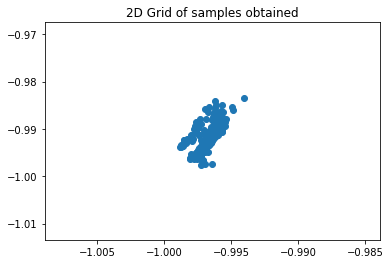

[Epoch 1000/10000] [Discriminator Loss: 1.506846] [Generator Loss: 0.166038]


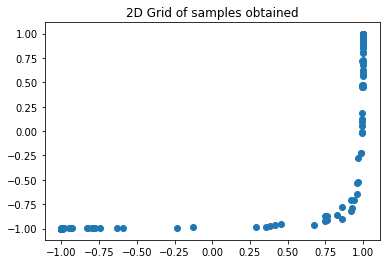

[Epoch 1500/10000] [Discriminator Loss: 0.546336] [Generator Loss: 0.421428]


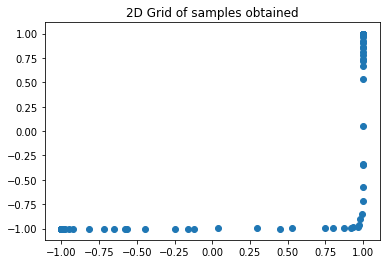

[Epoch 2000/10000] [Discriminator Loss: 0.628141] [Generator Loss: 0.339058]


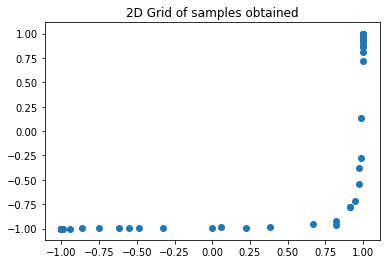

[Epoch 2500/10000] [Discriminator Loss: 0.571341] [Generator Loss: 0.497097]


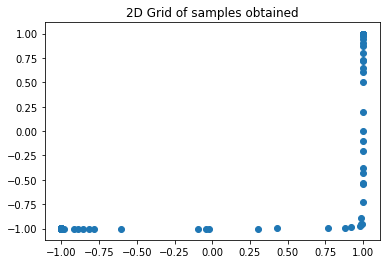

[Epoch 3000/10000] [Discriminator Loss: 0.784151] [Generator Loss: 0.246184]


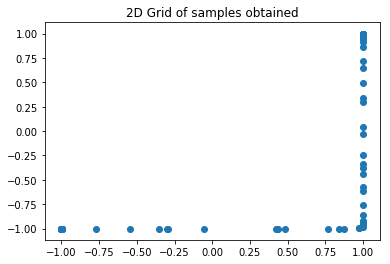

[Epoch 3500/10000] [Discriminator Loss: 0.404186] [Generator Loss: 0.601524]


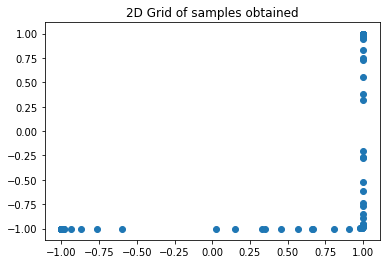

[Epoch 4000/10000] [Discriminator Loss: 0.398390] [Generator Loss: 0.645521]


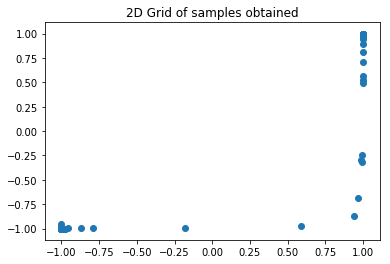

[Epoch 4500/10000] [Discriminator Loss: 0.565513] [Generator Loss: 0.628983]


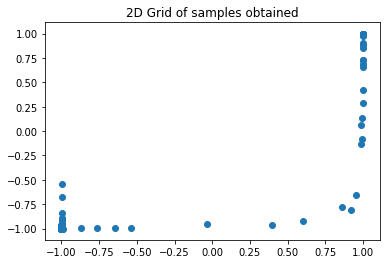

[Epoch 5000/10000] [Discriminator Loss: 0.499845] [Generator Loss: 0.558996]


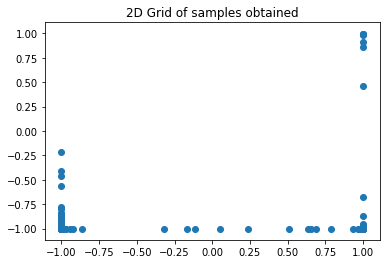

[Epoch 5500/10000] [Discriminator Loss: 0.477912] [Generator Loss: 0.530717]


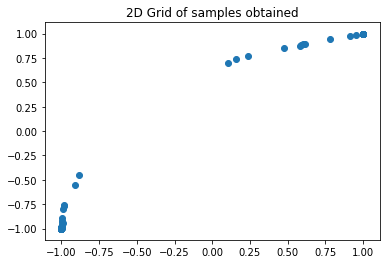

[Epoch 6000/10000] [Discriminator Loss: 1.532371] [Generator Loss: 0.111938]


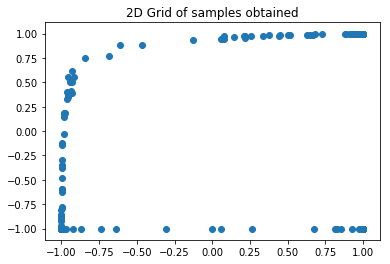

[Epoch 6500/10000] [Discriminator Loss: 1.773041] [Generator Loss: 0.798136]


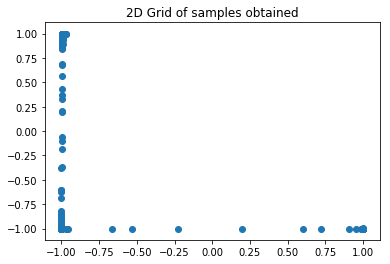

[Epoch 7000/10000] [Discriminator Loss: 3.496399] [Generator Loss: 0.139382]


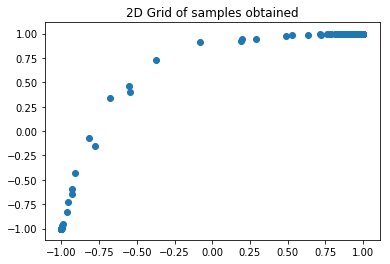

[Epoch 7500/10000] [Discriminator Loss: 1.214153] [Generator Loss: 0.338064]


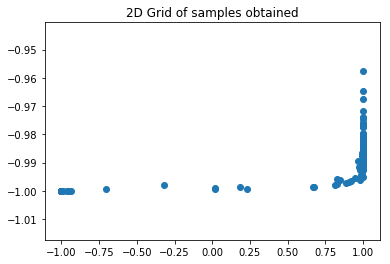

[Epoch 8000/10000] [Discriminator Loss: 1.335028] [Generator Loss: 0.205567]


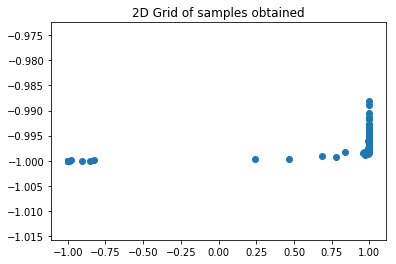

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# experiment parameters
num_epochs = 10000
num_samples_per_batch = 5
grid_length = 5
var = 0.0025
latent_dim = 100

# initialize things
generator = Generator(latent_dim=latent_dim)
discriminator = Discriminator()
adversarial_loss = torch.nn.BCELoss()
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    
# optimizers
learning_rate = 0.0002
b1 = 0.5
b2 = 0.999
amsgrad = True
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(b1, b2), amsgrad=amsgrad)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(b1, b2), amsgrad=amsgrad)

# underlay of true distribution
real_samples = sample_from_2dgrid(grid_length=grid_length, num_samples=num_samples)
x = [real_samples[i][0] for i in range(num_samples)]
y = [real_samples[i][1] for i in range(num_samples)]
plt.scatter(x, y)

# train the GAN
for epoch in range(num_epochs):
    # ground truths
    valid = Variable(Tensor(num_samples_per_batch, 1).fill_(1.0), requires_grad=False)
    fake = Variable(Tensor(num_samples_per_batch, 1).fill_(0.0), requires_grad=False)
    
    # input
    real_input = Variable(Tensor(sample_from_2dgrid(grid_length=grid_length, 
                                                    var=var, 
                                                    num_samples=num_samples_per_batch)))
    
    
    ########## Generator stuff ##########
    # sample latent z
    z = Variable(Tensor(np.random.normal(0, 1, (num_samples_per_batch, latent_dim))))
    
    # get generator output for the latent z
    fake_output = generator(z)
    
    # how well did we fool the discriminator?
    g_loss = adversarial_loss(discriminator(fake_output), valid)
    
    # gradient descent
    optimizer_G.zero_grad()
    g_loss.backward()
    optimizer_G.step()
    
    ########## Discriminator stuff ##########
    
    # see how well the discriminator can discriminate
    real_loss = adversarial_loss(discriminator(real_input), valid)
    fake_loss = adversarial_loss(discriminator(fake_output.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2
    
    # gradient descent
    d_loss.backward()
    optimizer_D.step()
    
    # progress prints and checkpointing (checkpointing not implemented)
    if epoch % 500 == 0:
        print("[Epoch %d/%d] [Discriminator Loss: %f] [Generator Loss: %f]" % 
              (epoch, num_epochs, d_loss.item(), g_loss.item()))
    
    if epoch % 500 == 0:
        num_samples_to_test = 200
        z = Variable(Tensor(np.random.normal(0, 1, (num_samples_to_test, latent_dim))))
        np_samples = generator(z).cpu().detach().numpy()
        x_sampled = [sample[0] for sample in np_samples]
        y_sampled = [sample[1] for sample in np_samples]
        plt.title("2D Grid of samples obtained")
        plt.scatter(x_sampled, y_sampled)
        plt.show()

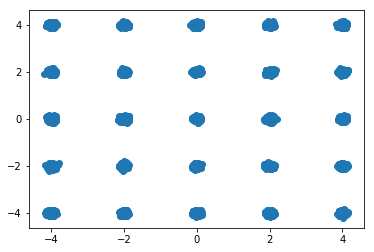

Grid length = 5


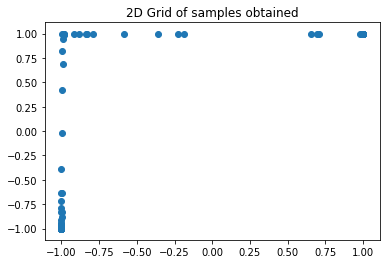

In [13]:
plt.clf()

# underlay of true distribution
real_samples = sample_from_2dgrid(grid_length=grid_length, num_samples=num_samples)
x = [real_samples[i][0] for i in range(num_samples)]
y = [real_samples[i][1] for i in range(num_samples)]
plt.scatter(x, y)

# look at some samples
num_samples_to_test = 200
z = Variable(Tensor(np.random.normal(0, 1, (num_samples_to_test, latent_dim))))
np_samples = generator(z).cpu().detach().numpy()
x_sampled = [sample[0] for sample in np_samples]
y_sampled = [sample[1] for sample in np_samples]
plt.title("2D Grid of samples obtained")
plt.scatter(x_sampled, y_sampled)

print("Grid length = %d" % grid_length)